In [1]:
#enable to plot with matplotlib
%matplotlib inline

In [2]:
import sys
sys.path.append('../../xs_proc/')
from visual_func import *
from xs_data_proc import *
from proc_data_ana import *
import matplotlib.pyplot as plt
from h5_data_search import id13_h5_search
import pyFAI
import numpy as np
import h5py
import os
import fabio
import time
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
# here load azimuth integrate2d data
azi,ct,qphi,q,path_list,path_idx,pttn_idx = load_proc('hdf_file/mount04_M22Lox_7_proc.h5')

# qphi is remeshed azimuth integrate2d pattern, the y axis is phi correlate to azimuth
# azi is the azimuth coordinate of qphi, q is the reciprocal coordinate of qph
# ct is the ion chamber counting
# path_list, path_idx and pttn_idx is information to locate the original diffraction pattern

In [4]:
# this will normalized the qphi pattern with ion chamber counting
qphi_norm = ct_normalization(qphi,ct)

In [5]:
# pyFAI let the intensity of mask pixel equal to zeros, to avoid this effect, we let 0 intensity pixel equal nan
# set high intensity threshold 1e6 to avoid the effects of dead pixels, which have very high intensity
qphi_norm[qphi_norm>1e6] = np.nan
qphi_norm[qphi_norm==0] = np.nan

In [6]:
# Map of intensity summation of every diffraction pattern 
int_map1 = sum_roi_2dmap(qphi_norm,azi,q)
# Map of intensity summation of certain q range of every diffraction
int_map2 = sum_roi_2dmap(qphi_norm,azi,q,qmin=0.03,qmax=0.1)
# Map of intensity summation of certain q and phi rangoe of every diffraction
int_map3 = sum_roi_2dmap(qphi_norm,azi,q,amin=90,amax=100,qmin=0.03,qmax=0.1)

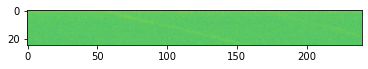

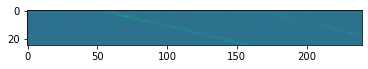

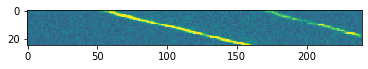

In [7]:
plt.subplots()
plt.imshow(int_map1,vmin=0,vmax=0.1)
plt.subplots()
plt.imshow(int_map2,vmin=0,vmax=0.1)
# fiber diffraction exhibit an enhanced intensity at equator direction
plt.subplots()
plt.imshow(int_map3,vmin=0,vmax=0.1)

Text(86, 8, '(x=76,y=5)')

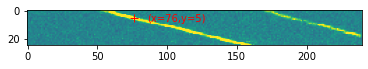

In [8]:
pttn_of_int_map(int_map3,path_list,path_idx,pttn_idx)
plt.plot(76,5,'r+',markersize=8)
plt.annotate('(x=76,y=5)',(86,8),color='r')

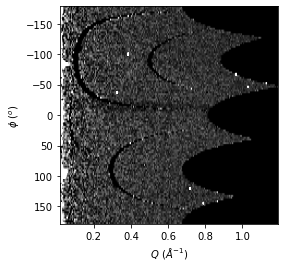

In [9]:
plot_qphi(qphi[5,76],q=q,a=azi,log=False,vmin=0,vmax=0.1,cmap='Greys_r')

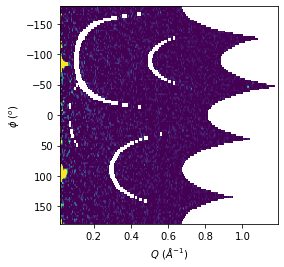

In [10]:
# subtract the background improve the contract of weak, background pattern chosen from above 
qphi_bk = np.nanmean(np.nanmean(qphi_norm[0:5,0:5],axis=0),axis=0)
plot_qphi(qphi[5,76]-qphi_bk,q=q,a=azi,log=False,vmin=0,vmax=0.1)

Text(0, 0.5, '$I\\,\\,(a.u.)$')

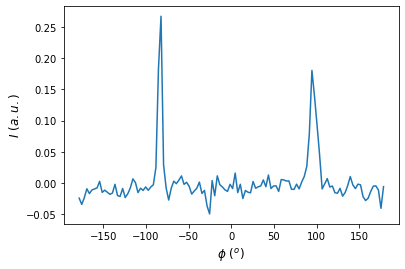

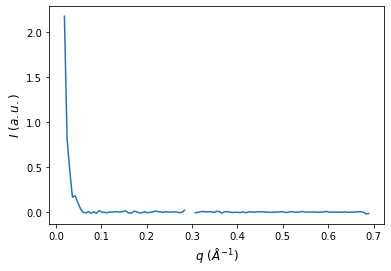

In [11]:
# here is azimuth intensity distribution or q range of 0.03 to 0.08
a1,Ia1 = sum_roi(qphi[5,76]-qphi_bk,
                 q=q,a=azi,qmin=0.03,qmax=0.08
                 ,vs_axis='a')
plt.subplots();plt.plot(a1,Ia1)
plt.xlabel(r'$\phi\,\,(^{o})$',fontsize=12)
plt.ylabel(r'$I\,\,(a.u.)$',fontsize=12)

# here is intensity distribution or azimuth range of 90 to 100 degree
q1,Iq1 = sum_roi(qphi[5,76]-qphi_bk,
                 q=q,a=azi,amin=90,amax=100
                 ,vs_axis='q')
plt.subplots();plt.plot(q1,Iq1)
plt.xlabel(r'$q\,\,(\AA^{-1})$',fontsize=12)
plt.ylabel(r'$I\,\,(a.u.)$',fontsize=12)

In [12]:
qids = np.argmin(np.abs(q-0.05))
oris,sidw = ori_determ2d(qphi_norm,azi,qids)

#oris[int_map3<0.05] = np.nan
#sidw[int_map3<0.05] = np.nan

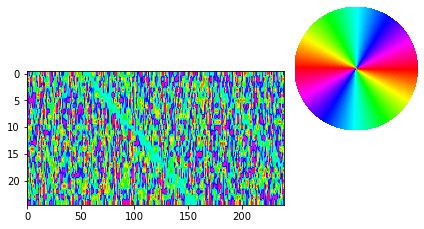

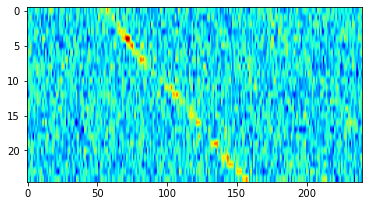

In [13]:
# here is degree for vals is -90 to 90, orientation had been adjusted within this range
def circle_sine_ramp(r_max=2, r_min=0, amp=np.pi/5, cycles=50,
                     power=2, nr=50, ntheta=1025):
    r, t = np.mgrid[r_min:r_max:nr*1j, 0:2*np.pi:ntheta*1j]
    r_norm = (r - r_min)/(r_max - r_min)
    vals = amp * r_norm**power * np.sin(cycles*t) + t
    vals = np.mod(vals, 2*np.pi) - np.pi
    vals[vals<0] += np.pi
    vals -= np.pi/2
    return t, r, vals

t, r, vals = circle_sine_ramp(cycles=0)
#plt.figure()
#plt.subplot(121)
#plt.pcolor(r*np.cos(t)+20,r*np.sin(t)+20,np.degrees(vals),cmap='hsv_r')
#plt.colorbar()
#plt.axis('image')
#plt.axis('off')

v = np.copy(oris)
v[v<0] += 180
v -= 90
#plt.subplot(122)
#plt.imshow(v,vmin=-90,vmax=90,cmap='hsv_r')
#plt.colorbar()

fig = plt.subplots()
ax1 = plt.subplot2grid((2,3),(0,0),colspan=2,rowspan=2)
ax2 = plt.subplot2grid((2,3),(0,2),colspan=1,rowspan=1)
ax1.imshow(v,vmin=-90,vmax=90,cmap='hsv_r',aspect=5)
ax2.pcolor(r*np.cos(t)+20,r*np.sin(t)+20,np.degrees(vals),cmap='hsv_r')
ax2.axis('image')
ax2.axis('off')
plt.tight_layout()

plt.subplots()
#plt.subplot(121)
#plt.imshow(np.log(1/wids),cmap='jet')
#plt.subplot(122)
plt.imshow(np.log(1/sidw),cmap='jet',aspect=5)